## Captcha Image generate

In [1]:
from captcha.image import ImageCaptcha
import random
import os

In [2]:
os.system('rm TrainImage/*')
os.system('rm TestImage/*')

random.seed()
captcha_len = 4
TrainImageNum = 3000
TestImageNum = 1000

In [3]:
for i in range(TrainImageNum): #Generate train img
    #img content
    gen_string=''
    for j in range(captcha_len):
        gen_string += str(random.randint(0,9))
    
    #output to img
    cap = ImageCaptcha()
    cap.write(gen_string,'TrainImage/'+gen_string+'_'+str(random.randint(0,10000))+'.jpg')

print('%d Train image generated'%(TrainImageNum))    

for i in range(TestImageNum): #Generate test img
    #img content
    gen_string=''
    for j in range(captcha_len):
        gen_string += str(random.randint(0,9))
    
    #output to img
    cap = ImageCaptcha()
    cap.write(gen_string,'TestImage/'+gen_string+'.jpg')

print('%d Test image generated'%(TestImageNum)) 

3000 Train image generated
1000 Test image generated


## CNN model

In [4]:
import numpy as np
from PIL import Image
from PIL import ImageEnhance
from sklearn import preprocessing
import os
import tensorflow.keras as keras
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.6
sess = InteractiveSession(config=config)

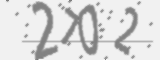

In [6]:
#Get train image name
fileName=[]
for i in os.listdir('TrainImage/'):
    fileName.append(i)

#Get train image size
img = Image.open('TrainImage/'+fileName[0]).convert('L')
width,height = img.size
img

In [7]:
# name2label( '0492_0000.jpg' ,1) will return [0,0,0,0,1,0,0,0,0,0] <- 4
def name2label(filename,digit):
    target = int(filename[digit])
    label = np.zeros(10)
    label[target]=1
    return label

def imagePreprocess(lst):
    for i in range( len(lst) ):
        img = lst[i]
        enhancer = ImageEnhance.Contrast(img) #increase contrast
        img = enhancer.enhance(4.0)
        img = np.asarray(img)
        img = img.astype('float32')
        img/=255
        lst[i]=img
    
    lst=np.array(lst)
    lst=lst.reshape(lst.shape[0],height,width,1)
    return lst

In [8]:
#Read x_train & y_train
imgList=[]
y_train=[]
for i in range(captcha_len):
    y_train.append([])
    
for i in fileName:
    img = Image.open('TrainImage/'+i).convert('L')
    imgList.append(img)
    for j in range(captcha_len):
        y_train[j].append(name2label(i,j))
        
x_train=imagePreprocess(imgList)
y_train = [y_train for y_train in np.asarray(y_train)]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
import tensorflow as tf

In [11]:
inf = layers.Input((height,width,1))
out = inf
out = layers.Conv2D(32,3,padding='same',activation='relu')(out)
out = layers.Conv2D(32,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)


out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.Conv2D(64,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out = layers.Conv2D(128,3,padding='same',activation='relu')(out)
out = layers.Conv2D(128,3,padding='same',activation='relu')(out)
out = layers.BatchNormalization()(out)
out = layers.MaxPooling2D(pool_size=(2,2))(out)

out=layers.Flatten()(out)
out=layers.Dropout(0.4)(out)
out=layers.Dense(1024,activation='relu')(out)
out=[layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out),layers.Dense(10,activation='softmax')(out)]
cnn=models.Model(inf,out)
cnn.summary()
#plot_model(cnn)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 60, 160, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 60, 160, 32)  320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 60, 160, 32)  9248        conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 60, 160, 32)  128         conv2d_9[0][0]                   
_______________________________________________________________________________________

In [12]:
#model train
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
cnn.fit(x_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
94/94 [==============================] - 3s 27ms/step - loss: 10.2143 - dense_6_loss: 2.3727 - dense_7_loss: 2.6163 - dense_8_loss: 2.7064 - dense_9_loss: 2.5190 - dense_6_accuracy: 0.2000 - dense_7_accuracy: 0.1513 - dense_8_accuracy: 0.1480 - dense_9_accuracy: 0.1637
Epoch 2/100
94/94 [==============================] - 2s 24ms/step - loss: 4.8358 - dense_6_loss: 0.8694 - dense_7_loss: 1.4452 - dense_8_loss: 1.5140 - dense_9_loss: 1.0072 - dense_6_accuracy: 0.6927 - dense_7_accuracy: 0.5020 - dense_8_accuracy: 0.4770 - dense_9_accuracy: 0.6610
Epoch 3/100
94/94 [==============================] - 2s 24ms/step - loss: 2.0969 - dense_6_loss: 0.2029 - dense_7_loss: 0.7667 - dense_8_loss: 0.8385 - dense_9_loss: 0.2887 - dense_6_accuracy: 0.9343 - dense_7_accuracy: 0.7580 - dense_8_accuracy: 0.7407 - dense_9_accuracy: 0.9127
Epoch 4/100
94/94 [==============================] - 2s 25ms/step - loss: 0.9638 - dense_6_loss: 0.0920 - dense_7_loss: 0.3418 - dense_8_loss: 0.4021 - dens

94/94 [==============================] - 2s 23ms/step - loss: 0.1182 - dense_6_loss: 0.0097 - dense_7_loss: 0.0599 - dense_8_loss: 0.0298 - dense_9_loss: 0.0188 - dense_6_accuracy: 0.9980 - dense_7_accuracy: 0.9867 - dense_8_accuracy: 0.9910 - dense_9_accuracy: 0.9953
Epoch 31/100
94/94 [==============================] - 2s 23ms/step - loss: 0.1083 - dense_6_loss: 0.0119 - dense_7_loss: 0.0430 - dense_8_loss: 0.0200 - dense_9_loss: 0.0334 - dense_6_accuracy: 0.9953 - dense_7_accuracy: 0.9867 - dense_8_accuracy: 0.9943 - dense_9_accuracy: 0.9903
Epoch 32/100
94/94 [==============================] - 2s 24ms/step - loss: 0.0896 - dense_6_loss: 0.0087 - dense_7_loss: 0.0279 - dense_8_loss: 0.0313 - dense_9_loss: 0.0217 - dense_6_accuracy: 0.9977 - dense_7_accuracy: 0.9923 - dense_8_accuracy: 0.9927 - dense_9_accuracy: 0.9947
Epoch 33/100
94/94 [==============================] - 2s 25ms/step - loss: 0.0744 - dense_6_loss: 0.0189 - dense_7_loss: 0.0211 - dense_8_loss: 0.0172 - dense_9_loss: 

94/94 [==============================] - 2s 23ms/step - loss: 0.1357 - dense_6_loss: 0.0187 - dense_7_loss: 0.0567 - dense_8_loss: 0.0359 - dense_9_loss: 0.0245 - dense_6_accuracy: 0.9957 - dense_7_accuracy: 0.9883 - dense_8_accuracy: 0.9923 - dense_9_accuracy: 0.9940
Epoch 60/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0988 - dense_6_loss: 0.0069 - dense_7_loss: 0.0289 - dense_8_loss: 0.0493 - dense_9_loss: 0.0137 - dense_6_accuracy: 0.9977 - dense_7_accuracy: 0.9950 - dense_8_accuracy: 0.9917 - dense_9_accuracy: 0.9957
Epoch 61/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0879 - dense_6_loss: 0.0109 - dense_7_loss: 0.0185 - dense_8_loss: 0.0419 - dense_9_loss: 0.0165 - dense_6_accuracy: 0.9980 - dense_7_accuracy: 0.9953 - dense_8_accuracy: 0.9923 - dense_9_accuracy: 0.9950
Epoch 62/100
94/94 [==============================] - 2s 23ms/step - loss: 0.0866 - dense_6_loss: 0.0161 - dense_7_loss: 0.0097 - dense_8_loss: 0.0491 - dense_9_loss: 

94/94 [==============================] - 2s 25ms/step - loss: 0.0736 - dense_6_loss: 0.0162 - dense_7_loss: 0.0302 - dense_8_loss: 0.0186 - dense_9_loss: 0.0086 - dense_6_accuracy: 0.9987 - dense_7_accuracy: 0.9950 - dense_8_accuracy: 0.9977 - dense_9_accuracy: 0.9983
Epoch 89/100
94/94 [==============================] - 2s 25ms/step - loss: 0.0343 - dense_6_loss: 0.0119 - dense_7_loss: 0.0018 - dense_8_loss: 0.0163 - dense_9_loss: 0.0044 - dense_6_accuracy: 0.9973 - dense_7_accuracy: 0.9990 - dense_8_accuracy: 0.9980 - dense_9_accuracy: 0.9987
Epoch 90/100
94/94 [==============================] - 2s 25ms/step - loss: 0.0596 - dense_6_loss: 0.0150 - dense_7_loss: 0.0249 - dense_8_loss: 0.0056 - dense_9_loss: 0.0141 - dense_6_accuracy: 0.9967 - dense_7_accuracy: 0.9957 - dense_8_accuracy: 0.9983 - dense_9_accuracy: 0.9970
Epoch 91/100
94/94 [==============================] - 2s 25ms/step - loss: 0.0853 - dense_6_loss: 0.0133 - dense_7_loss: 0.0255 - dense_8_loss: 0.0297 - dense_9_loss: 

In [13]:
def decode(pred):
    ans=[]
    for target in range(pred[0].shape[0]):
        string=''
        for i in range(captcha_len):
            string+=str(int(np.where( pred[i][target] == max(pred[i][target]) )[0]))
        ans.append(string)
    return ans

In [14]:
#Test image
testName=[]
for i in os.listdir('TestImage/'):
    testName.append('TestImage/'+i)

testList=[]
for i in testName:
    img = Image.open(i).convert('L')
    testList.append(img)
        
temp=testList[1]
x_test=imagePreprocess(testList)
pred=cnn.predict(x_test)
pred=decode(pred)
acc=0
for i in range(len(pred)):
    if pred[i]==testName[i][10:captcha_len+10]:
        acc+=1
print('accurate: ',acc)

accurate:  895


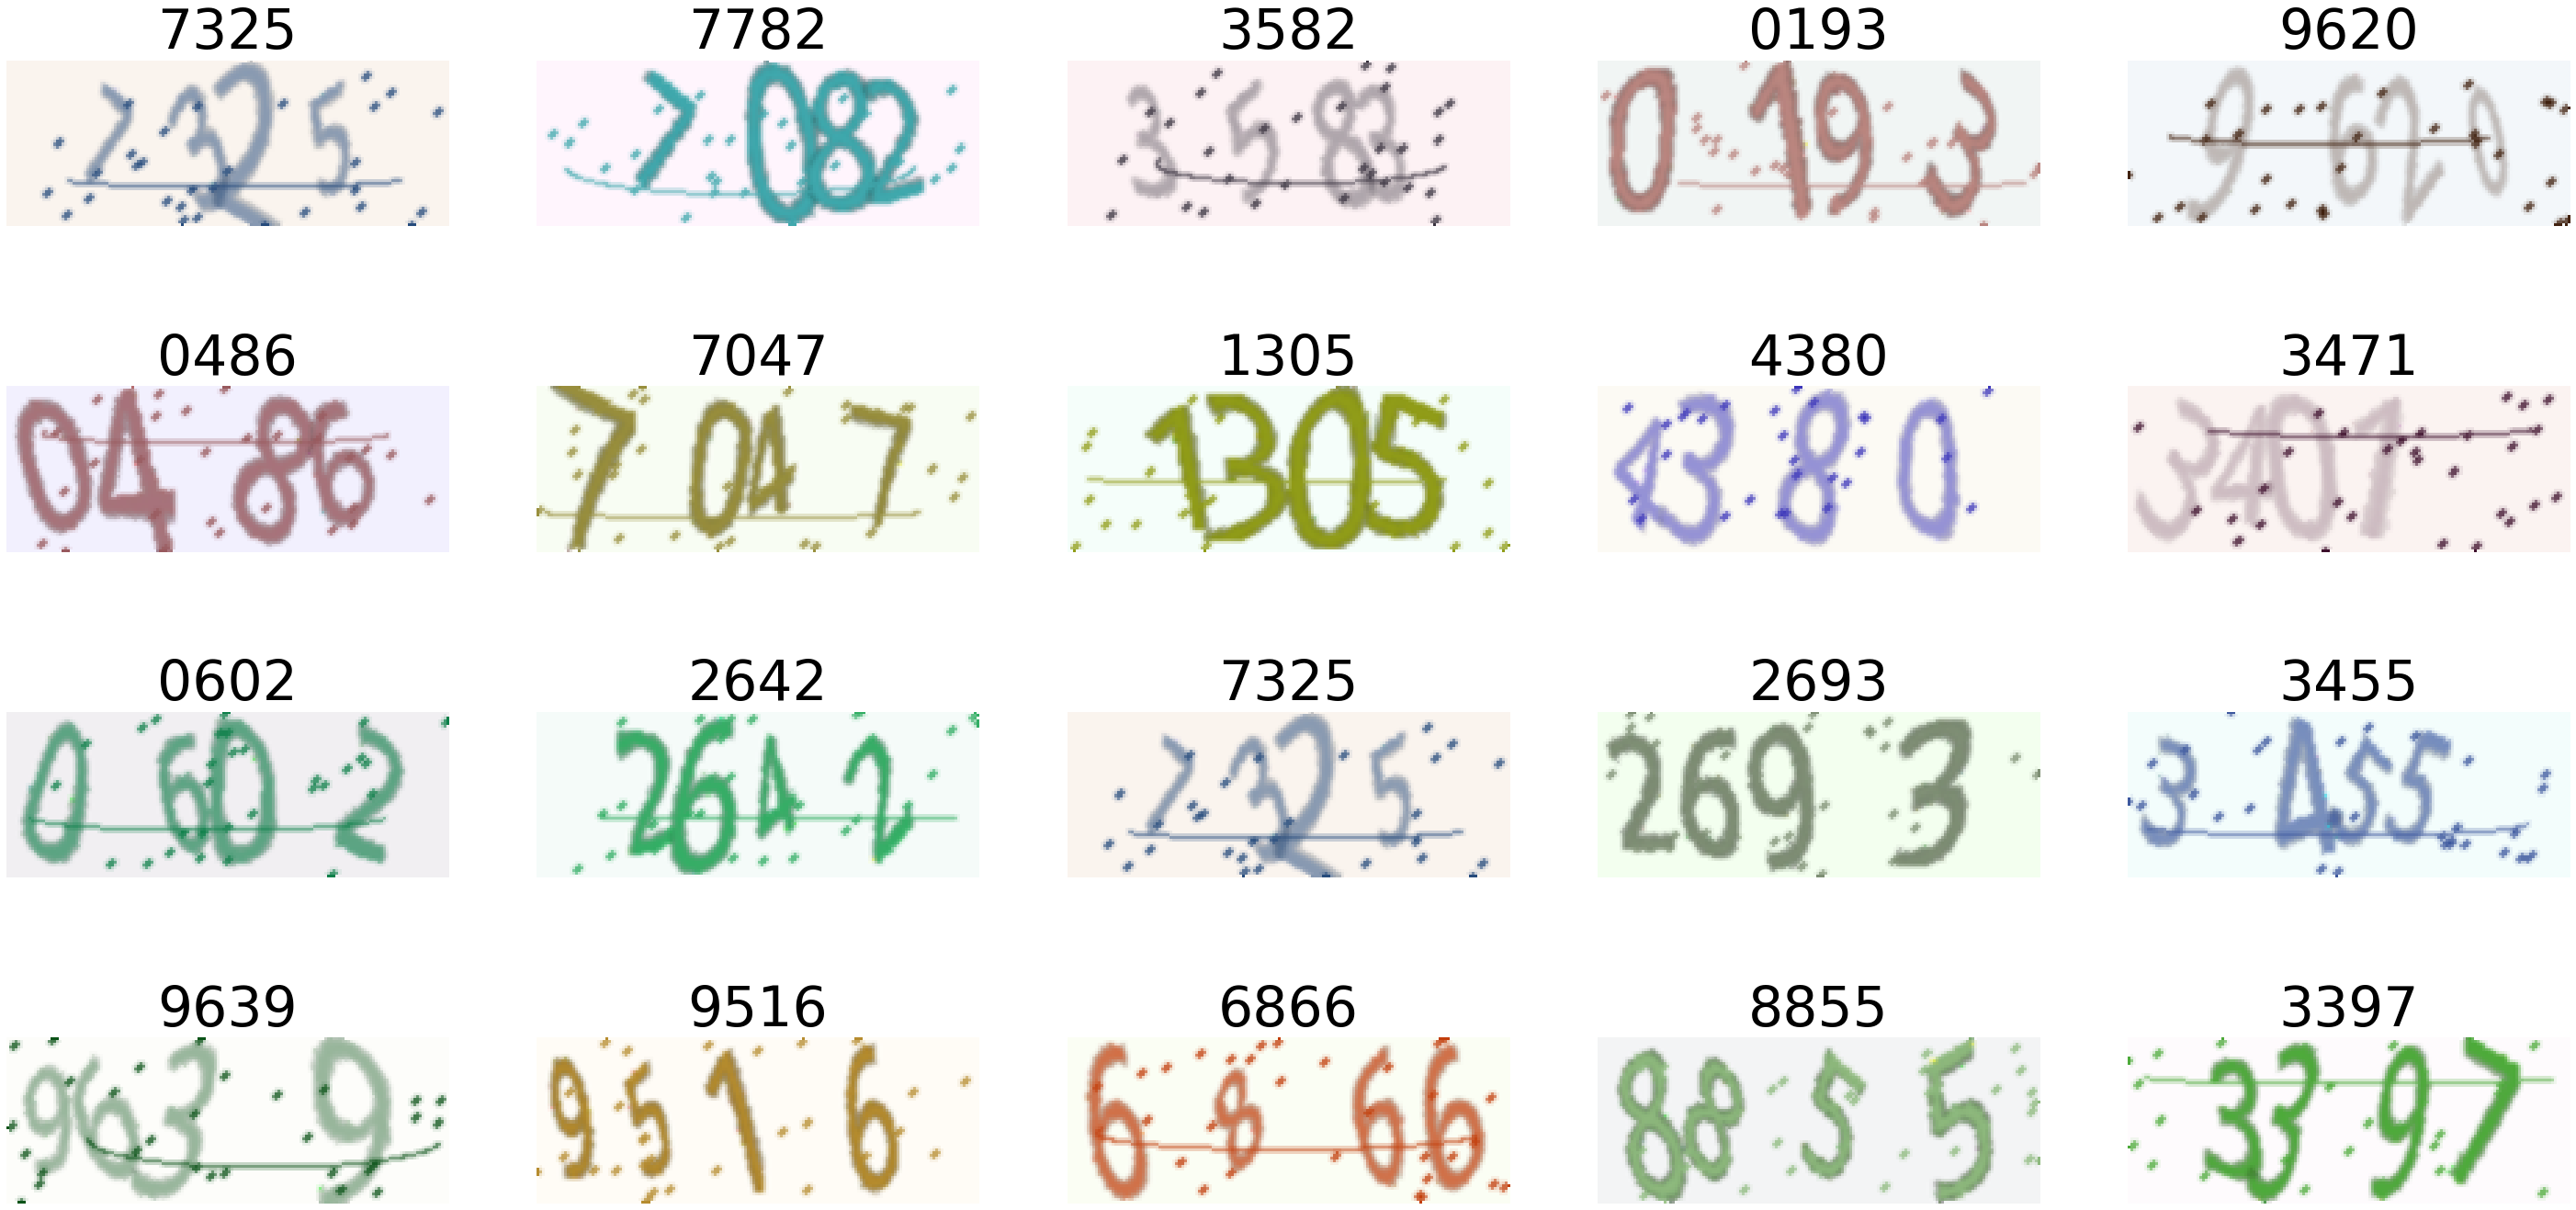

In [18]:
#Show result
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(50,25))
for j in range(20):
    i=random.randint(0,100)
    temp=plt.imread(testName[i])
    plt.subplot(4,5,j+1)
    plt.imshow(temp)
    plt.title(pred[i],fontsize=60)
    plt.axis('off')
# result=plt.imread(testName[1])
# plt.imshow(result)
# plt.axis('off')
# print(pred[1])